In [1]:
import numpy as np
import torch
import json
import matplotlib.pyplot as plt

from utils.aoj import AspenOpenJets, JetFeatures, ParticleClouds
from utils.tensorclass import TensorMultiModal
from utils.plotting import plot_hist_and_ratio

# dir_path = "/home/df630/Multimodal-Bridges/experiments/results/comet/multimodal-jets/"

# baseline = TensorMultiModal.load_from(dir_path + "/data/paths_sample.h5")
# baseline = baseline[-1].clone().squeeze(-1, 'discrete')
# cfm = JetFeatures(baseline)

num_jets = 100_000
max_num_particles = 150

aoj = AspenOpenJets(data_dir="/home/df630/Multimodal-Bridges/data/aoj", data_files="RunG_batch1.h5")

test, _ = aoj(num_jets=num_jets,
            download=False,      
            max_num_particles=max_num_particles,           
            features={"continuous": ['pt', 'eta_rel', 'phi_rel'], "discrete": "tokens"},
            pt_order=True,
            padding='zeros',
            )

test = test.squeeze(-1, 'discrete')
aoj = JetFeatures(test) 

/home/df630/Multimodal-flows/multimodal_flows/utils/aoj.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_discrete_feats.append(torch.tensor(feats[features["discrete"]]))


Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and pt-ordered Winner-Takes-All recombination
Calculating N-subjettiness
#--------------------------------------------------------------------------
#                         FastJet release 3.4.3
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPY

In [2]:

sample = TensorMultiModal.load_from('/home/df630/Multimodal-flows/jet_sequences/generated_sample_3000steps_1.0temp.h5')
sample = sample.squeeze(-1, 'discrete')
mmf = JetFeatures(sample)

Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and pt-ordered Winner-Takes-All recombination
Calculating N-subjettiness


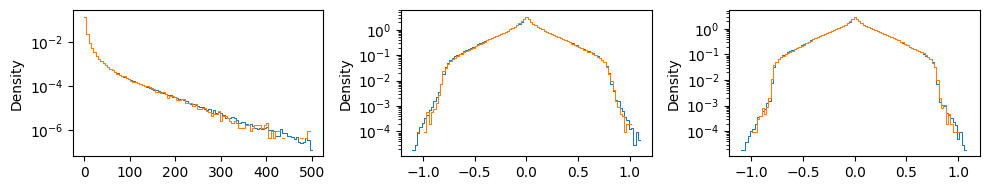

In [3]:
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(10, 2))

bins = np.linspace(0, 500, 100)
sns.histplot(aoj.constituents.pt[aoj.constituents.mask_bool].numpy(), bins=bins, discrete=False, stat="density", element="step", fill=False, ax=ax[0], log_scale=(False, True), lw=0.75, label="AOJ (truth)")
sns.histplot(mmf.constituents.pt[mmf.constituents.mask_bool].numpy(), bins=bins, discrete=False, stat="density", element="step", fill=False, ax=ax[0], log_scale=(False, True), lw=0.75, label="MMF - ParticleFormer")



bins = np.linspace(-1.1, 1.1, 100)
sns.histplot(aoj.constituents.eta_rel[aoj.constituents.mask_bool].numpy(),  bins=bins, discrete=False, stat="density", element="step", fill=False, ax=ax[1], log_scale=(False, True), lw=0.75)
sns.histplot(mmf.constituents.eta_rel[mmf.constituents.mask_bool].numpy(),  bins=bins, discrete=False, stat="density", element="step", fill=False, ax=ax[1], log_scale=(False, True), lw=0.75)


bins = np.linspace(-1.1, 1.1, 100)
sns.histplot(aoj.constituents.phi_rel[aoj.constituents.mask_bool].numpy(),  bins=bins, discrete=False, stat="density", element="step", fill=False, ax=ax[2], log_scale=(False, True), lw=0.75)
sns.histplot(mmf.constituents.phi_rel[mmf.constituents.mask_bool].numpy(),  bins=bins, discrete=False, stat="density", element="step", fill=False, ax=ax[2], log_scale=(False, True), lw=0.75)

plt.tight_layout()


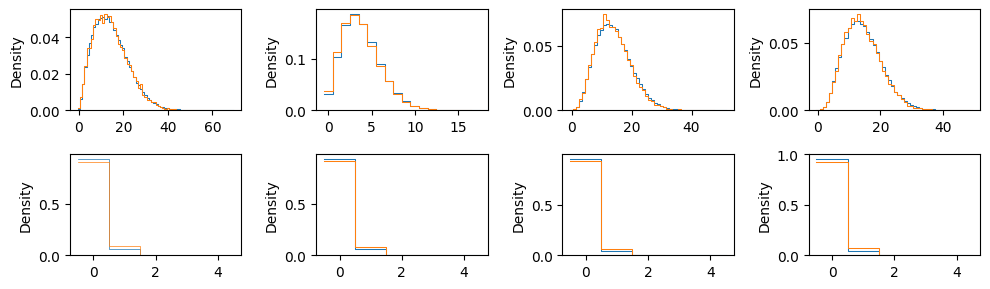

In [4]:
import seaborn as sns

fig, ax = plt.subplots(2, 4, figsize=(10, 3))

sns.histplot(aoj.constituents.num_Photon.numpy(), discrete=True, stat="density", element="step", fill=False, ax=ax[0,0], lw=0.75)
sns.histplot(mmf.constituents.num_Photon.numpy(), discrete=True, stat="density", element="step", fill=False, ax=ax[0,0], lw=0.75)

sns.histplot(aoj.constituents.num_NeutralHadron.numpy(), discrete=True, stat="density", element="step", fill=False, ax=ax[0,1], lw=0.75)
sns.histplot(mmf.constituents.num_NeutralHadron.numpy(), discrete=True, stat="density", element="step", fill=False, ax=ax[0,1], lw=0.75)

sns.histplot(aoj.constituents.num_NegativeHadron.numpy(), discrete=True, stat="density", element="step", fill=False, ax=ax[0,2], lw=0.75)
sns.histplot(mmf.constituents.num_NegativeHadron.numpy(), discrete=True, stat="density", element="step", fill=False, ax=ax[0,2], lw=0.75)

sns.histplot(aoj.constituents.num_PositiveHadron.numpy(), discrete=True, stat="density", element="step", fill=False, ax=ax[0,3], lw=0.75)
sns.histplot(mmf.constituents.num_PositiveHadron.numpy(), discrete=True, stat="density", element="step", fill=False, ax=ax[0,3], lw=0.75)

sns.histplot(aoj.constituents.num_Electron.numpy(), discrete=True, stat="density", element="step", fill=False, ax=ax[1,0], lw=0.5)
sns.histplot(mmf.constituents.num_Electron.numpy(), discrete=True, stat="density", element="step", fill=False, ax=ax[1,0], lw=0.5)

sns.histplot(aoj.constituents.num_Positron.numpy(), discrete=True, stat="density", element="step", fill=False, ax=ax[1,1], lw=0.75)
sns.histplot(mmf.constituents.num_Positron.numpy(), discrete=True, stat="density", element="step", fill=False, ax=ax[1,1], lw=0.75)

sns.histplot(aoj.constituents.num_Muon.numpy(), discrete=True, stat="density", element="step", fill=False, ax=ax[1,2], lw=0.75)
sns.histplot(mmf.constituents.num_Muon.numpy(), discrete=True, stat="density", element="step", fill=False, ax=ax[1,2], lw=0.75)

sns.histplot(aoj.constituents.num_AntiMuon.numpy(), discrete=True, stat="density", element="step", fill=False, ax=ax[1,3], lw=0.75)
sns.histplot(mmf.constituents.num_AntiMuon.numpy(), discrete=True, stat="density", element="step", fill=False, ax=ax[1,3], lw=0.75)

plt.tight_layout()


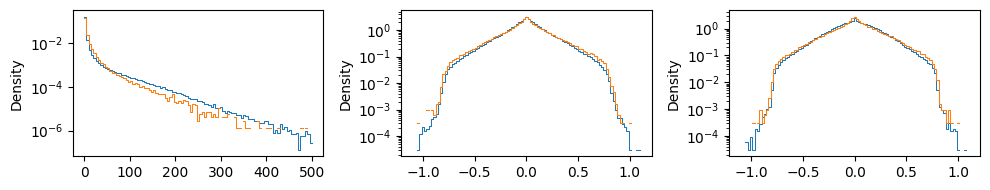

In [5]:
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(10, 2))

bins = np.linspace(0, 500, 100)
sns.histplot(aoj.constituents.pt_Photon.numpy(), bins=bins, discrete=False, stat="density", element="step", fill=False, ax=ax[0], log_scale=(False, True), lw=0.75, label="AOJ (truth)")
sns.histplot(mmf.constituents.pt_Photon.numpy(), bins=bins, discrete=False, stat="density", element="step", fill=False, ax=ax[0], log_scale=(False, True), lw=0.75, label="MMF - ParticleFormer")



bins = np.linspace(-1.1, 1.1, 100)
sns.histplot(aoj.constituents.eta_Photon.numpy(),  bins=bins, discrete=False, stat="density", element="step", fill=False, ax=ax[1], log_scale=(False, True), lw=0.75)
sns.histplot(mmf.constituents.eta_Photon.numpy(),  bins=bins, discrete=False, stat="density", element="step", fill=False, ax=ax[1], log_scale=(False, True), lw=0.75)


bins = np.linspace(-1.1, 1.1, 100)
sns.histplot(aoj.constituents.phi_Photon.numpy(),  bins=bins, discrete=False, stat="density", element="step", fill=False, ax=ax[2], log_scale=(False, True), lw=0.75)
sns.histplot(mmf.constituents.phi_Photon.numpy(),  bins=bins, discrete=False, stat="density", element="step", fill=False, ax=ax[2], log_scale=(False, True), lw=0.75)

plt.tight_layout()

In [24]:
aoj.constituents.pt_Photon.shape

torch.Size([1455103])

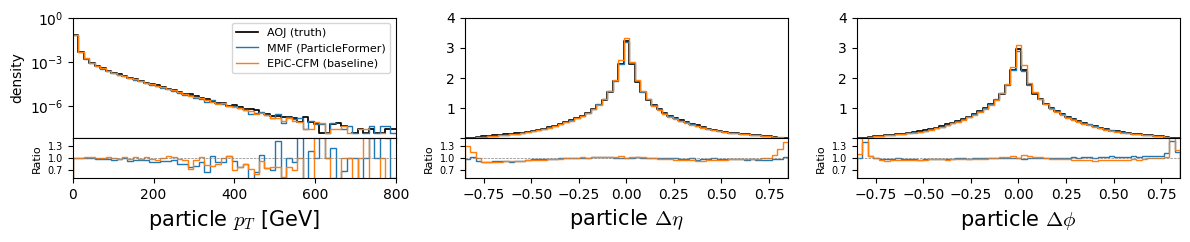

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(12, 2.5), gridspec_kw={'height_ratios':[3,1], 'hspace': 0}, sharex='col')

plot_hist_and_ratio(aoj.constituents, 
                    mmf.constituents,
                    cfm.constituents, 
                    axes[0, 0], axes[1, 0], 
                    apply_map_test='mask_bool',
                    apply_map_gen='mask_bool',
                    apply_map_gen_ref='mask_bool',
                    feat='pt', 
                    xlim=(0, 800), 
                    ylim=(0,1),  
                    num_bins=60, 
                    color_test = 'k',
                    lw=1.0,
                    xlabel= r'particle $p_T$ [GeV]', 
                    ylabel='density', 
                    legend1='MMF', 
                    legend2='EPiC-CFM (baseline)', 
                    log_scale=(False, True))

plot_hist_and_ratio(aoj.constituents, 
                    mmf.constituents, 
                    cfm.constituents,
                    axes[0, 1], axes[1, 1], 
                    apply_map_test='mask_bool',
                    apply_map_gen='mask_bool',
                    apply_map_gen_ref='mask_bool',
                    feat='eta_rel', 
                    xlim=(-0.85, 0.85),  
                    ylim=(0, 4), 
                    num_bins=60, 
                    color_test = 'k',
                    lw=1.0,
                    xlabel=r'particle $\Delta\eta$')
                    
plot_hist_and_ratio(aoj.constituents, 
                    mmf.constituents, 
                    cfm.constituents, 
                    axes[0, 2], axes[1, 2], 
                    apply_map_test='mask_bool',
                    apply_map_gen='mask_bool',
                    apply_map_gen_ref='mask_bool',
                    feat='phi_rel', 
                    xlim=(-0.85, 0.85),  
                    ylim=(0, 4),  
                    num_bins=60, 
                    color_test = 'k',
                    lw=1.0,
                    xlabel=r'particle $\Delta\phi$')

axes[0, 1].set_yticks([0,1,2,3,4])
axes[0, 1].set_yticklabels(['',1,2,3,4])
axes[0, 2].set_yticks([0,1,2,3,4])
axes[0, 2].set_yticklabels(['',1,2,3,4])

plt.tight_layout()
plt.savefig("particle_level_feats.png", dpi=500)
plt.show()


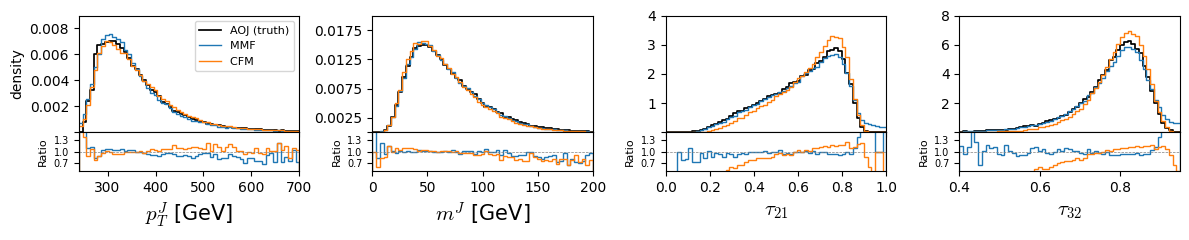

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(12, 2.5), gridspec_kw={'height_ratios':[3,1], 'hspace': 0}, sharex='col')


plot_hist_and_ratio(aoj, 
                    mmf, 
                    cfm,
                    axes[0, 0], axes[1, 0], 
                    feat='pt', 
                    xlim=(240, 700), 
                    ylim=(0, 0.009),  
                    num_bins=60, 
                    color_test = 'k',
                    lw=1.0,
                    xlabel= r'$p_T^J$ [GeV]', 
                    ylabel='density', 
                    legend1='MMF ', 
                    legend2='CFM ', )

plot_hist_and_ratio(aoj, 
                    mmf, 
                    cfm,
                    axes[0, 1], axes[1, 1], 
                    feat='m', 
                    xlim=(0, 200),  
                    ylim=(0, 0.02), 
                    num_bins=60, 
                    color_test = 'k',
                    lw=1.0,
                    xlabel=r'$m^J$ [GeV]')
                    
plot_hist_and_ratio(aoj, 
                    mmf, 
                    cfm, 
                    axes[0, 2], axes[1, 2], 
                    feat='tau21', 
                    xlim=(0,1), 
                    ylim=(0,4),  
                    num_bins=60,
                    color_test = 'k',
                    lw=1.0, 
                    xlabel=r'$\tau_{21}$')

plot_hist_and_ratio(aoj, 
                    mmf, 
                    cfm, 
                    axes[0, 3], axes[1, 3], 
                    feat='tau32', 
                    xlim=(0.4,0.95), 
                    ylim=(0,8),  
                    num_bins=60,
                    color_test = 'k',
                    lw=1.0, 
                    xlabel=r'$\tau_{32}$')



axes[0, 0].set_yticks([0, 0.002,0.004, 0.006, 0.008])
axes[0, 0].set_yticklabels(['', 0.002,0.004, 0.006, 0.008])
axes[0, 1].set_yticks([0,0.0025,0.0075,0.0125,0.0175])
axes[0, 1].set_yticklabels(['',0.0025,0.0075,0.0125,0.0175])
axes[0, 2].set_yticks([0,1,2,3,4])
axes[0, 2].set_yticklabels(['',1,2,3,4])
axes[0, 3].set_yticks([0,2,4,6,8])
axes[0, 3].set_yticklabels(['',2,4,6,8])

plt.tight_layout()
plt.savefig("jets_level_feats.png", dpi=500)
plt.show()


In [56]:

mmf_photons = sample.clone()
mmf_photons.continuous *= (mmf_photons.discrete==1).unsqueeze(-1)
mmf_photons.discrete *= mmf_photons.discrete==1
mmf_photons = JetFeatures(mmf_photons)


aoj_photons = test.clone()
aoj_photons.continuous *= (aoj_photons.discrete==1).unsqueeze(-1)
aoj_photons.discrete *= aoj_photons.discrete==1
aoj_photons = JetFeatures(aoj_photons)



Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and pt-ordered Winner-Takes-All recombination
Calculating N-subjettiness


Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and pt-ordered Winner-Takes-All recombination
Calculating N-subjettiness


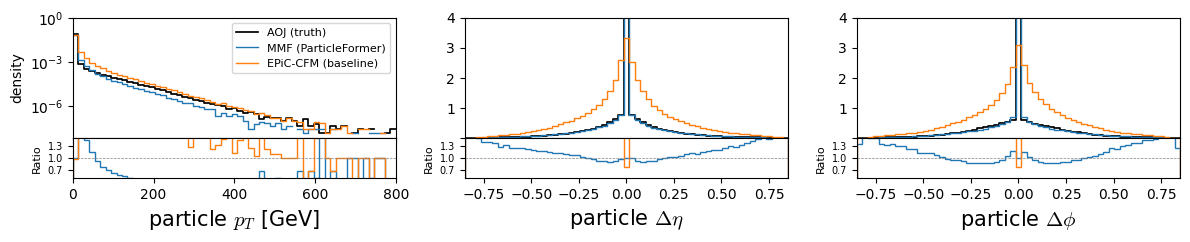

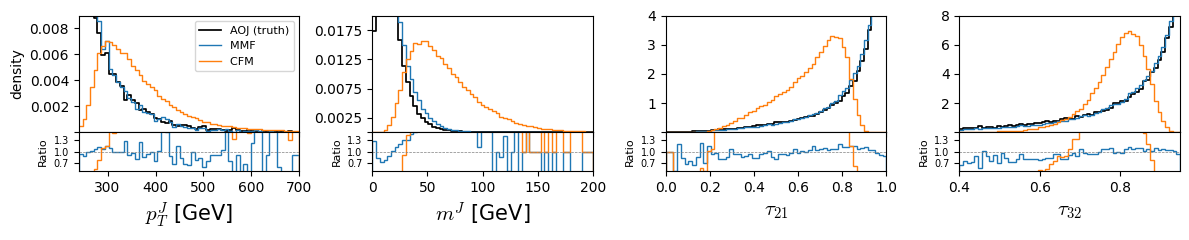

In [58]:
fig, axes = plt.subplots(2, 3, figsize=(12, 2.5), gridspec_kw={'height_ratios':[3,1], 'hspace': 0}, sharex='col')

plot_hist_and_ratio(aoj_photons.constituents, 
                    mmf_photons.constituents,
                    cfm.constituents, 
                    axes[0, 0], axes[1, 0], 
                    apply_map_test='mask_bool',
                    apply_map_gen='mask_bool',
                    apply_map_gen_ref='mask_bool',
                    feat='pt', 
                    xlim=(0, 800), 
                    ylim=(0,1),  
                    num_bins=60, 
                    color_test = 'k',
                    lw=1.0,
                    xlabel= r'particle $p_T$ [GeV]', 
                    ylabel='density', 
                    legend1='MMF (ParticleFormer)', 
                    legend2='EPiC-CFM (baseline)', 
                    log_scale=(False, True))

plot_hist_and_ratio(aoj_photons.constituents, 
                    mmf_photons.constituents, 
                    cfm.constituents,
                    axes[0, 1], axes[1, 1], 
                    apply_map_test='mask_bool',
                    apply_map_gen='mask_bool',
                    apply_map_gen_ref='mask_bool',
                    feat='eta_rel', 
                    xlim=(-0.85, 0.85),  
                    ylim=(0, 4), 
                    num_bins=60, 
                    color_test = 'k',
                    lw=1.0,
                    xlabel=r'particle $\Delta\eta$')
                    
plot_hist_and_ratio(aoj_photons.constituents, 
                    mmf_photons.constituents, 
                    cfm.constituents, 
                    axes[0, 2], axes[1, 2], 
                    apply_map_test='mask_bool',
                    apply_map_gen='mask_bool',
                    apply_map_gen_ref='mask_bool',
                    feat='phi_rel', 
                    xlim=(-0.85, 0.85),  
                    ylim=(0, 4),  
                    num_bins=60, 
                    color_test = 'k',
                    lw=1.0,
                    xlabel=r'particle $\Delta\phi$')

axes[0, 1].set_yticks([0,1,2,3,4])
axes[0, 1].set_yticklabels(['',1,2,3,4])
axes[0, 2].set_yticks([0,1,2,3,4])
axes[0, 2].set_yticklabels(['',1,2,3,4])

plt.tight_layout()
plt.savefig("particle_level_feats.png", dpi=500)
plt.show()



fig, axes = plt.subplots(2, 4, figsize=(12, 2.5), gridspec_kw={'height_ratios':[3,1], 'hspace': 0}, sharex='col')


plot_hist_and_ratio(aoj_photons, 
                    mmf_photons, 
                    cfm,
                    axes[0, 0], axes[1, 0], 
                    feat='pt', 
                    xlim=(240, 700), 
                    ylim=(0, 0.009),  
                    num_bins=60, 
                    color_test = 'k',
                    lw=1.0,
                    xlabel= r'$p_T^J$ [GeV]', 
                    ylabel='density', 
                    legend1='MMF ', 
                    legend2='CFM ', )

plot_hist_and_ratio(aoj_photons, 
                    mmf_photons, 
                    cfm,
                    axes[0, 1], axes[1, 1], 
                    feat='m', 
                    xlim=(0, 200),  
                    ylim=(0, 0.02), 
                    num_bins=60, 
                    color_test = 'k',
                    lw=1.0,
                    xlabel=r'$m^J$ [GeV]')
                    
plot_hist_and_ratio(aoj_photons, 
                    mmf_photons, 
                    cfm, 
                    axes[0, 2], axes[1, 2], 
                    feat='tau21', 
                    xlim=(0,1), 
                    ylim=(0,4),  
                    num_bins=60,
                    color_test = 'k',
                    lw=1.0, 
                    xlabel=r'$\tau_{21}$')

plot_hist_and_ratio(aoj_photons, 
                    mmf_photons, 
                    cfm, 
                    axes[0, 3], axes[1, 3], 
                    feat='tau32', 
                    xlim=(0.4,0.95), 
                    ylim=(0,8),  
                    num_bins=60,
                    color_test = 'k',
                    lw=1.0, 
                    xlabel=r'$\tau_{32}$')



axes[0, 0].set_yticks([0, 0.002,0.004, 0.006, 0.008])
axes[0, 0].set_yticklabels(['', 0.002,0.004, 0.006, 0.008])
axes[0, 1].set_yticks([0,0.0025,0.0075,0.0125,0.0175])
axes[0, 1].set_yticklabels(['',0.0025,0.0075,0.0125,0.0175])
axes[0, 2].set_yticks([0,1,2,3,4])
axes[0, 2].set_yticklabels(['',1,2,3,4])
axes[0, 3].set_yticks([0,2,4,6,8])
axes[0, 3].set_yticklabels(['',2,4,6,8])

plt.tight_layout()
plt.savefig("jets_level_feats.png", dpi=500)
plt.show()

In [22]:


class JetChargeDipole:

    """
    Compute pT-weighted jet charge  Q_kappa  and
    the 2-point electric-dipole moment  d2  for every jet.
    """

    def __init__(self, data):

        """
        data: an object with attributes
              .continuous  (pT, eta, phi) padded with zeros
              .charge      integer charges (−1, 0, +1)
              .mask        boolean mask of real particles
        """
        self.x = data.constituents.continuous      # (n, D, 3)
        self.Q = data.constituents.charge          # (n, D)
        self.mask = data.constituents.mask_bool    # (n, D)

        # option: keep only jets that have ≥2 (for d2) or ≥1 (for Q) particles

        n_part = self.mask.sum(dim=1)
        self.valid_Q  = n_part >= 1
        self.valid_d2 = n_part >= 2

    def _delta_R(self, eta, phi):
        d_eta = eta.unsqueeze(1) - eta.unsqueeze(0)
        d_phi = torch.remainder(phi.unsqueeze(1) - phi.unsqueeze(0) + np.pi,
                                2 * np.pi) - np.pi
        return torch.sqrt(d_eta**2 + d_phi**2)

    def charge_and_dipole(self, kappa: float = 1.0, beta: float = 1.0):
        """
        Compute the pT-weighted jet charge  Q_kappa  and the electric–dipole
        moment  d2  for every jet in the batch.

        Returns
        -------
        Q_kappa : 1-D tensor, length = n_valid_jets
        d2      : 1-D tensor, length = n_valid_jets
                (jets with <2 particles get filtered out, like _auto_ecf)
        """

        Q0_list, Qkappa_list, d2_list = [],[],[]     # results for *all* jets
        mask_2_parts = (self.mask.sum(dim=1) >= 2)   # ≥2 real particles

        for idx, jet in enumerate(self.x):        # iterate over jets   (D,3) view

            pT, eta, phi = jet[:, 0], jet[:, 1], jet[:, 2]
            mask = pT > 0
            Q = self.Q[idx][mask].float() 
            pT = pT[mask]
            eta = eta[mask]
            phi = phi[mask]

            # -------------------------------------------------
            #   Jet charge   Q_kappa
            # -------------------------------------------------

            jet_pT = pT.sum()
            
            if jet_pT == 0:
                Qkappa = torch.nan
                Q0 = torch.nan
            else:
                Qkappa = (Q * pT**kappa).sum() / jet_pT
                Q0 = Q.sum() 

            # -------------------------------------------------
            #   Electric-dipole   d2
            # -------------------------------------------------

            if len(jet) < 2:
                d2 = torch.nan
            else:
                # pair-wise ΔR
                d_eta = eta.unsqueeze(1) - eta.unsqueeze(0)
                d_phi = torch.remainder(phi.unsqueeze(1) - phi.unsqueeze(0) + torch.pi,
                                        2 * torch.pi) - torch.pi
                R_ij  = torch.sqrt(d_eta**2 + d_phi**2).pow(beta)   # (N,N)

                weight   = (Q * pT).unsqueeze(1) * (Q * pT).unsqueeze(0)
                dip_mat  = weight * R_ij / 2.0          # divide-by-2 like _auto_ecf
                d2       = dip_mat.sum() / jet_pT**2

            Q0_list.append(Q0)
            Qkappa_list.append(Qkappa)
            d2_list.append(d2)

        # tensor-ise and filter exactly like _auto_ecf
        Q0 = torch.tensor(Q0_list)
        Qkappa  = torch.tensor(Qkappa_list)
        d2 = torch.tensor(d2_list)

        Q0  = Q0[mask_2_parts]
        Qkappa = Qkappa[mask_2_parts]
        d2 = d2[mask_2_parts]

        return Q0, Qkappa, d2


In [52]:
aoj.constituents.charge

tensor([[ 0., -1.,  1.,  ...,  0.,  0.,  0.],
        [ 1.,  1., -1.,  ...,  0.,  0.,  0.],
        [-1.,  1., -1.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  1.,  1.,  ...,  0.,  0.,  0.],
        [ 1., -1.,  1.,  ...,  0.,  0.,  0.],
        [ 1., -1.,  1.,  ...,  0.,  0.,  0.]])

In [24]:
cfm_dipole = JetChargeDipole(cfm)           # `data` is your padded batch
aoj_dipole = JetChargeDipole(aoj)           # `data` is your padded batch
mmf_dipole = JetChargeDipole(mmf)

aoj_charge, aoj_jet_charge, aoj_jet_dipole = aoj_dipole.charge_and_dipole()
mmf_charge, mmf_jet_charge, mmf_jet_dipole = mmf_dipole.charge_and_dipole()
cfm_charge, cfm_jet_charge, cfm_jet_dipole = cfm_dipole.charge_and_dipole()


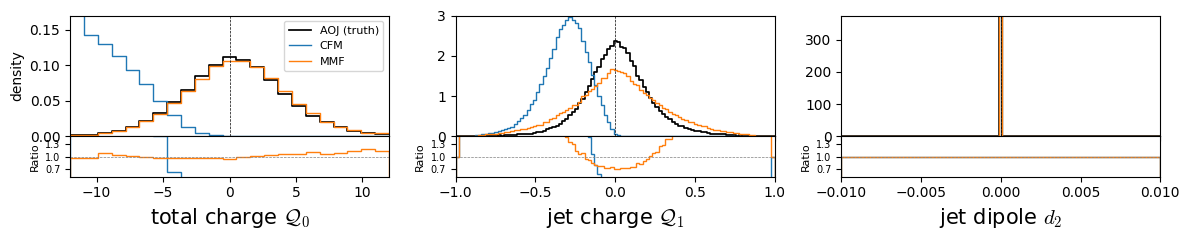

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(12, 2.5), gridspec_kw={'height_ratios':[3,1], 'hspace': 0.0}, sharex='col')

num_bins=100

plot_hist_and_ratio(aoj, 
                    cfm, 
                    mmf,  
                    axes[0, 0], axes[1, 0], 
                    feat='charge',
                    xlim=(-12,12), 
                    ylim=(0, 0.17),
                    color_test = 'k',
                    lw=1.0, 
                    num_bins=24, 
                    # discrete=True,
                    xlabel=r'total charge $\mathcal{Q}_0$', 
                    ylabel='density', 
                    legend1='CFM', 
                    legend2='MMF')


plot_hist_and_ratio(aoj, 
                    cfm, 
                    mmf,  
                    axes[0, 1], axes[1, 1], 
                    feat='jet_charge',
                    xlim=(-1,1), 
                    ylim=(0, 3),
                    color_test = 'k',
                    lw=1.0, 
                    num_bins=num_bins, 
                    xlabel=r'jet charge $\mathcal{Q}_1$', 
                    )

plot_hist_and_ratio(aoj, 
                    cfm, 
                    mmf,  
                    axes[0, 2], axes[1, 2], 
                    feat='charge',
                    xlim=(-.01,.01), 
                    ylim=(0, 375),
                    color_test = 'k',
                    lw=1.0, 
                    num_bins=num_bins, 
                    xlabel=r'jet dipole $d_2$',
                    # log_scale=(False, True),

                    )
# add vertical liune at x=0
axes[0, 0].axvline(x=0, color='k', linestyle='--', lw=0.5)
axes[0, 1].axvline(x=0, color='k', linestyle='--', lw=0.5)
axes[0, 2].axvline(x=0, color='k', linestyle='--', lw=0.5)

plt.tight_layout()
plt.savefig("dipole.png", dpi=500)
plt.show()


In [35]:
import numpy as np
import torch
from argparse import ArgumentParser
from pytorch_lightning.loggers import CometLogger
import pytorch_lightning as L
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from transformers import GPT2Config

from utils.tensorclass import TensorMultiModal
from utils.aoj import AspenOpenJets 
from utils.datasets import MultiModalDataset, DataCoupling, data_coupling_collate_fn
from utils.callbacks import GPTGeneratorCallback
from model.MMF import MultiModalFlowBridge


experiment_id = "efb5ee16ee754d639dfd041b33e8883c"
num_jets = 100

mmf = MultiModalFlowBridge.load_from_checkpoint(f"/home/df630/Multimodal-flows/jet_sequences/{experiment_id}/checkpoints/best.ckpt")
mmf.num_timesteps = 100
#...dataset & dataloaders:


aoj = AspenOpenJets(data_dir="/home/df630/Multimodal-Bridges/data/aoj", data_files="RunG_batch1.h5")
test, metadata = aoj(num_jets=num_jets,
                download=False,
                features={"continuous": ['pt', 'eta_rel', 'phi_rel'], "discrete": "tokens"},
                pt_order=True,
                padding='zeros')


gauss_noise = torch.randn_like(test.continuous) * test.mask
cat_noise = torch.randint_like(test.discrete, 1, mmf.vocab_size) * test.mask
t0 = torch.full((len(cat_noise),), mmf.time_eps)  # (B) t_0=eps

source = TensorMultiModal(continuous=gauss_noise, discrete=cat_noise, mask=test.mask.clone(), time=t0)
source = source.to(mmf.device)


data = DataCoupling(source=source, target=TensorMultiModal())

sample = mmf.simulate_dynamics(data)
sample.target.apply_mask()
sample = sample.target.detach().cpu() 


/home/df630/Multimodal-flows/multimodal_flows/utils/aoj.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_discrete_feats.append(torch.tensor(feats[features["discrete"]]))


In [39]:
metadata['mean'], metadata['std'] 

([7.728357791900635, 0.004547098185867071, -0.010292614810168743],
 [20.062654495239258, 0.25494733452796936, 0.24738295376300812])

In [41]:
test.continuous[test.mask.squeeze(-1) > 0].mean(0).tolist() 

[7.728357791900635, 0.004547098185867071, -0.010292614810168743]

In [46]:
 test.continuous.float().view(-1,3)[0], test.continuous[test.mask.squeeze(-1) > 0][0]

(tensor([ 9.9438e+01, -3.8081e-02, -1.1468e-03]),
 tensor([ 9.9438e+01, -3.8081e-02, -1.1468e-03]))

In [38]:

m = test.continuous.float().view(-1, 3).mean(dim=0)
s = test.continuous.float().view(-1,3).std(dim=0)
m, s

(tensor([ 2.4133e+00,  1.4199e-03, -3.2140e-03]),
 tensor([11.7686,  0.1425,  0.1383]))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))

sns.histplot(test.continuous[...,0], discrete=True, stat="density", element="step", fill=True, lw=0.0)
sns.histplot(sample.continuous[...,0], discrete=True, stat="density",element="step", fill=False, lw=0.75)

In [14]:

import matplotlib.pyplot as plt
import seaborn as sns

def plot_flavor_feats(sample, particle_set, path_dir=None):

    #...Low-level feats

    fig, ax = plt.subplots(2, 4, figsize=(10,3.5))

    sns.histplot((particle_set.discrete == 1).sum(dim=1), discrete=True, stat="density", element="step", fill=True, ax=ax[0, 0], lw=0.0)
    sns.histplot((sample == 1).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 0], lw=0.75)
    ax[0, 0].set_xlabel(r"$N_{\gamma}$")

    sns.histplot((particle_set.discrete == 2).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 1],lw=0.0)
    sns.histplot((sample == 2).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 1],lw=0.75)
    ax[0, 1].set_xlabel(r"$N_{h^0}$")

    sns.histplot((particle_set.discrete == 3).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 2],lw=0.0)
    sns.histplot((sample == 3).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 2],lw=0.75)
    ax[0, 2].set_xlabel(r"$N_{h^{-}}$")

    sns.histplot((particle_set.discrete == 4).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 3],lw=0.0)
    sns.histplot((sample == 4).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 3],lw=0.75)
    ax[0, 3].set_xlabel(r"$N_{h^{+}}$")

    sns.histplot((particle_set.discrete == 5).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 0],lw=0.0)
    sns.histplot((sample == 5).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 0],lw=0.75)
    ax[1, 0].set_xlabel(r"$N_{e^{-}}$")

    sns.histplot((particle_set.discrete == 6).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 1],lw=0.0)
    sns.histplot((sample == 6).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 1],lw=0.75)
    ax[1, 1].set_xlabel(r"$N_{e^{+}}$")

    sns.histplot((particle_set.discrete == 7).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 2],lw=0.0)
    sns.histplot((sample == 7).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 2],lw=0.75)
    ax[1, 2].set_xlabel(r"$N_{\mu^{-}}$")

    sns.histplot((particle_set.discrete == 8).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 3],lw=0.0)
    sns.histplot((sample == 8).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 3],lw=0.75)
    ax[1, 3].set_xlabel(r"$N_{\mu^{+}}$")

    plt.tight_layout()
    for a in ax.flatten():
        a.legend([], [], frameon=False)


    #...High-level feats

    fig, ax = plt.subplots(2, 3, figsize=(8,3.5))

    sns.histplot((particle_set.discrete > 0).sum(dim=1), discrete=True, stat="density", element="step", fill=True, ax=ax[0, 0], lw=0.0)
    sns.histplot((sample > 0).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 0], lw=0.75)
    ax[0, 0].set_xlabel(r"$N$")

    sns.histplot(((particle_set.discrete > 1) & (particle_set.discrete < 5)).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 1],lw=0.0)
    sns.histplot(((sample > 1) & (sample < 5)).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 1],lw=0.75)
    ax[0, 1].set_xlabel(r"$N_{\rm had}$")

    sns.histplot((particle_set.discrete > 4).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 2],lw=0.0)
    sns.histplot((sample > 4).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 2],lw=0.75)
    ax[0, 2].set_xlabel(r"$N_{\rm lep}$")

    sns.histplot(((particle_set.discrete == 1) | (particle_set.discrete == 2)).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 0],lw=0.0)
    sns.histplot(((sample == 1) | (sample == 2)).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 0],lw=0.75)
    ax[1, 0].set_xlabel(r"$N_{0}$")

    sns.histplot(((particle_set.discrete == 3) | (particle_set.discrete == 5) | (particle_set.discrete == 7)).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 1],lw=0.0)
    sns.histplot(((sample == 3) | (sample == 5) | (sample == 7)).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 1],lw=0.75)
    ax[1, 1].set_xlabel(r"$N_{-}$")

    sns.histplot(((particle_set.discrete == 4) | (particle_set.discrete == 6) | (particle_set.discrete == 8)).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 2],lw=0.0)
    sns.histplot(((sample == 4) | (sample == 6) | (sample == 8)).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 2],lw=0.75)
    ax[1, 2].set_xlabel(r"$N_{+}$")


    plt.tight_layout()
    for a in ax.flatten():
        a.legend([], [], frameon=False)



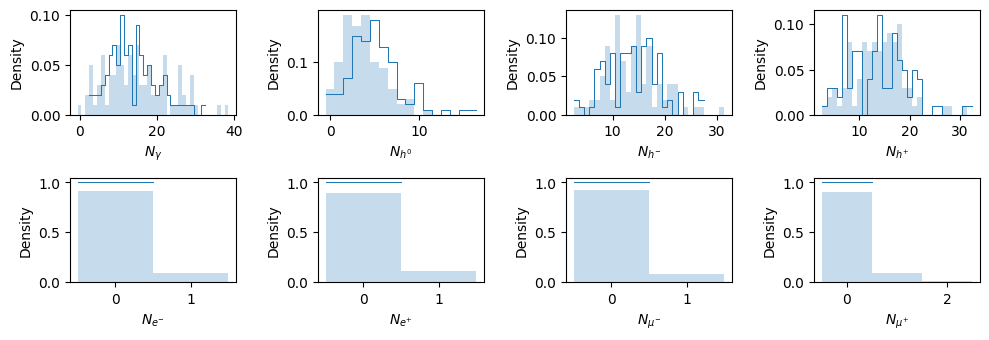

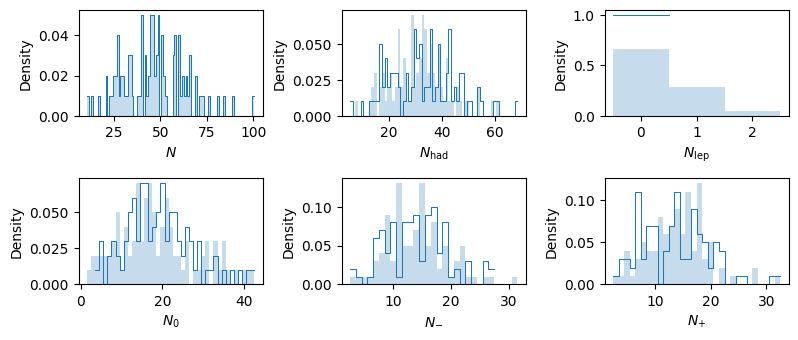

In [15]:

plot_flavor_feats(sample.discrete, 
                  test)

<Axes: ylabel='Density'>

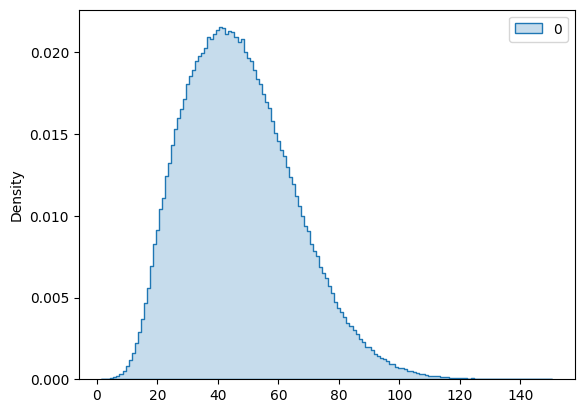

In [2]:
import seaborn as sns

sns.histplot((particle_set.discrete > 0).sum(dim=1), 
             discrete=True,
             stat="density",
             element="step",
             )

In [47]:
import torch
from pytorch_lightning.loggers import CometLogger
import pytorch_lightning as L
from torch.utils.data import DataLoader, random_split
from tensorclass import TensorMultiModal
from datamodules.datasets import MultiModalDataset, DataCoupling, data_coupling_collate_fn
from model.GPT import JetFlavorSeqGPT


experiment_id = 'efb5ee16ee754d639dfd041b33e8883c'
gpt = JetFlavorSeqGPT.load_from_checkpoint(f"/home/df630/Multimodal-flows/jet_sequences/{experiment_id}/checkpoints/best.ckpt", map_location="cpu",)


ModuleNotFoundError: No module named 'tensorclass'

In [53]:
import torch.nn.functional as F

prompts = torch.full((1000, 1), gpt.start_token, dtype=torch.long)
attention_mask = torch.ones_like(prompts)

samples = gpt.model.generate(
                            input_ids=prompts,
                            attention_mask=attention_mask,
                            max_new_tokens=gpt.max_seq_length + 2, 
                            do_sample=True,
                            temperature=gpt.temperature,
                            top_k=gpt.top_k,
                            eos_token_id=gpt.end_token,
                            pad_token_id=gpt.pad_token,
                            )

preds = F.pad(samples, (0, gpt.max_seq_length + 2 - samples.shape[1]), value=gpt.pad_token)
preds = torch.where(preds >= gpt.start_token, 0, preds)[:, 1:-1]  # remove start token

In [54]:
preds

tensor([[3, 3, 4,  ..., 0, 0, 0],
        [3, 2, 1,  ..., 0, 0, 0],
        [3, 1, 4,  ..., 0, 0, 0],
        ...,
        [3, 2, 1,  ..., 0, 0, 0],
        [1, 3, 3,  ..., 0, 0, 0],
        [4, 1, 3,  ..., 0, 0, 0]])

In [3]:
sample = np.load('/home/df630/Multimodal-flows/jet_sequences/sample.npy')
sample = torch.from_numpy(sample).long()
sample.shape

torch.Size([500000, 150])

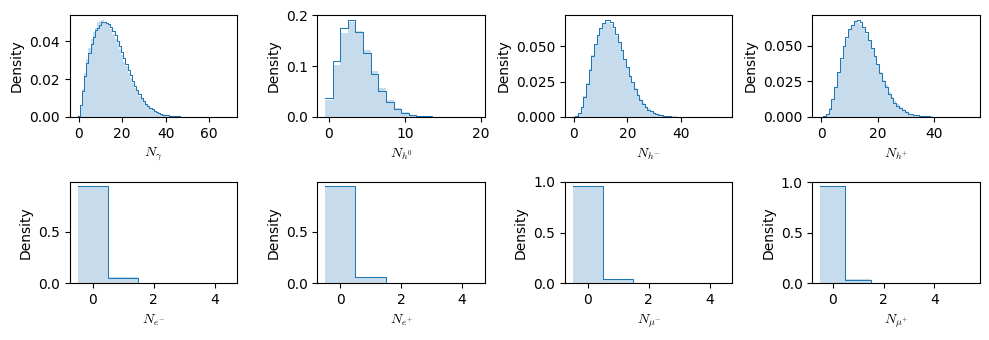

In [34]:
import seaborn as sns

fig, ax = plt.subplots(2, 4, figsize=(10,3.5))

sns.histplot((particle_set.discrete == 1).sum(dim=1), discrete=True, stat="density", element="step", fill=True, ax=ax[0, 0], lw=0.0)
sns.histplot((sample == 1).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 0], lw=0.75)
ax[0, 0].set_xlabel(r"$N_{\gamma}$")

sns.histplot((particle_set.discrete == 2).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 1],lw=0.0)
sns.histplot((sample == 2).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 1],lw=0.75)
ax[0, 1].set_xlabel(r"$N_{h^0}$")

sns.histplot((particle_set.discrete == 3).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 2],lw=0.0)
sns.histplot((sample == 3).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 2],lw=0.75)
ax[0, 2].set_xlabel(r"$N_{h^{-}}$")

sns.histplot((particle_set.discrete == 4).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 3],lw=0.0)
sns.histplot((sample == 4).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 3],lw=0.75)
ax[0, 3].set_xlabel(r"$N_{h^{+}}$")

sns.histplot((particle_set.discrete == 5).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 0],lw=0.0)
sns.histplot((sample == 5).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 0],lw=0.75)
ax[1, 0].set_xlabel(r"$N_{e^{-}}$")

sns.histplot((particle_set.discrete == 6).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 1],lw=0.0)
sns.histplot((sample == 6).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 1],lw=0.75)
ax[1, 1].set_xlabel(r"$N_{e^{+}}$")

sns.histplot((particle_set.discrete == 7).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 2],lw=0.0)
sns.histplot((sample == 7).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 2],lw=0.75)
ax[1, 2].set_xlabel(r"$N_{\mu^{-}}$")

sns.histplot((particle_set.discrete == 8).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 3],lw=0.0)
sns.histplot((sample == 8).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 3],lw=0.75)
ax[1, 3].set_xlabel(r"$N_{\mu^{+}}$")

plt.tight_layout()
for a in ax.flatten():
    a.legend([], [], frameon=False)
plt.show()


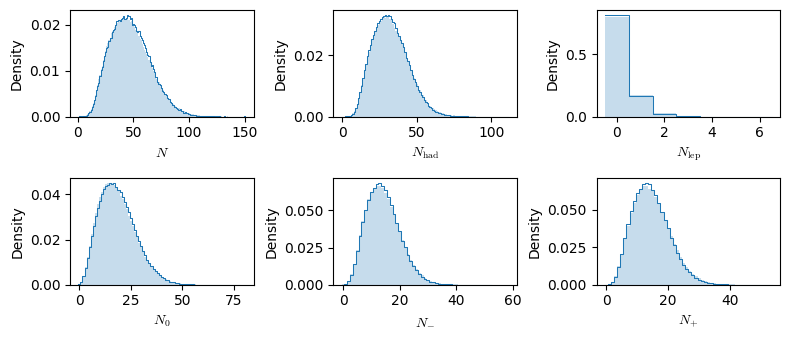

In [49]:
import seaborn as sns

fig, ax = plt.subplots(2, 3, figsize=(8,3.5))

sns.histplot((particle_set.discrete > 0).sum(dim=1), discrete=True, stat="density", element="step", fill=True, ax=ax[0, 0], lw=0.0)
sns.histplot((sample > 0).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 0], lw=0.75)
ax[0, 0].set_xlabel(r"$N$")

sns.histplot(((particle_set.discrete > 1) & (particle_set.discrete < 5)).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 1],lw=0.0)
sns.histplot(((sample > 1) & (sample < 5)).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 1],lw=0.75)
ax[0, 1].set_xlabel(r"$N_{\rm had}$")

sns.histplot((particle_set.discrete > 4).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[0, 2],lw=0.0)
sns.histplot((sample > 4).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[0, 2],lw=0.75)
ax[0, 2].set_xlabel(r"$N_{\rm lep}$")

sns.histplot(((particle_set.discrete == 1) | (particle_set.discrete == 2)).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 0],lw=0.0)
sns.histplot(((sample == 1) | (sample == 2)).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 0],lw=0.75)
ax[1, 0].set_xlabel(r"$N_{0}$")

sns.histplot(((particle_set.discrete == 3) | (particle_set.discrete == 5) | (particle_set.discrete == 7)).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 1],lw=0.0)
sns.histplot(((sample == 3) | (sample == 5) | (sample == 7)).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 1],lw=0.75)
ax[1, 1].set_xlabel(r"$N_{-}$")

sns.histplot(((particle_set.discrete == 4) | (particle_set.discrete == 6) | (particle_set.discrete == 8)).sum(dim=1), discrete=True, stat="density",element="step", fill=True, ax=ax[1, 2],lw=0.0)
sns.histplot(((sample == 4) | (sample == 6) | (sample == 8)).sum(dim=1), discrete=True, stat="density",element="step", fill=False, ax=ax[1, 2],lw=0.75)
ax[1, 2].set_xlabel(r"$N_{+}$")


plt.tight_layout()
for a in ax.flatten():
    a.legend([], [], frameon=False)
plt.show()

## Token ocurrence per jet

In [4]:
token_freqs = torch.tensor(
    [
        (data.isPhoton.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isNeutralHadron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isNegativeHadron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isPositiveHadron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isElectron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isPositron.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isMuon.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
        (data.isAntiMuon.sum(dim=1) / data.multiplicity.squeeze(-1)).mean(),
    ]
)

In [12]:
batch = next(iter(train_dataloader))
state = mjb.sample_bridges(batch).to(mjb.device)
target = batch.target.discrete.squeeze(-1).to(mjb.device)

# run one forward+loss
outputs = mjb.model(
    input_ids      = state.discrete.squeeze(-1).long(),
    attention_mask= state.mask.squeeze(-1).long(),
    labels         = target.long(),
)
print("✔ forward OK, loss=", outputs.loss.item())

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


✔ forward OK, loss= 2.0418574810028076


tensor([[ 0., 10.,  3.,  ...,  0.,  0.,  0.],
        [ 0., 13.,  1.,  ...,  0.,  0.,  1.],
        [ 0.,  3.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  9.,  1.,  ...,  0.,  1.,  0.],
        [ 0.,  6.,  1.,  ...,  0.,  1.,  0.],
        [ 0., 29.,  4.,  ...,  0.,  0.,  0.]])


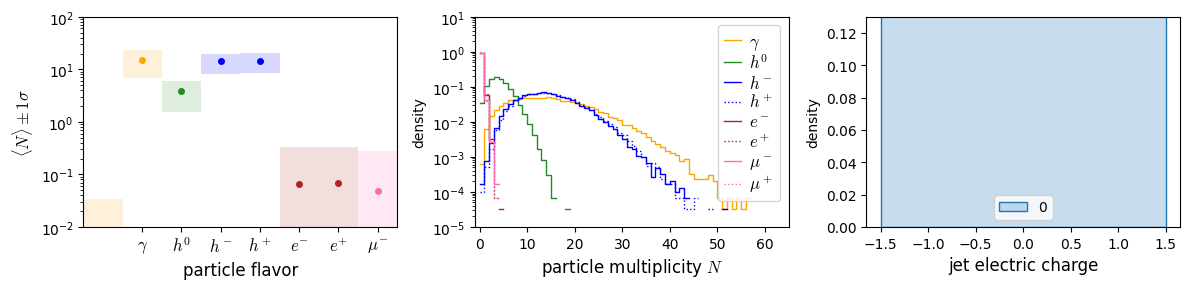

In [7]:
_, ax = plt.subplots(1, 3, figsize=(12, 3))

jets.plot_flavor_count_per_jet(
    markersize=8,
    color=[
        "orange",
        "orange",
        "forestgreen",
        "blue",
        "blue",
        "firebrick",
        "firebrick",
        "hotpink",
        "hotpink",
    ],
    ax=ax[0],
)

fill = False
alpha = 1 

data.histplot('num_Photon',ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100), binwidth=1,log_scale=(False, True),  stat='density', color='orange',lw=1,  label=r'$\gamma$')
data.histplot("num_NeutralHadron",  ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100), binwidth=1, log_scale=(False, True),  stat='density', color='forestgreen',lw=1,  label=r'$h^0$')
data.histplot("num_NegativeHadron", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100), binwidth=1, log_scale=(False, True) , stat='density', color='blue', lw=1, label=r'$h^-$')
data.histplot("num_PositiveHadron",  ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100), binwidth=1, log_scale=(False, True), ls=':', stat='density', color='blue', lw=1, label=r'$h^+$')
data.histplot("num_Electron", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100),binwidth=1, log_scale=(False, True),  stat='density', color='firebrick', lw=1,  label=r'$e^-$')
data.histplot("num_Positron", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100),binwidth=1, log_scale=(False, True),  stat='density', color='firebrick', lw=1, ls=':', label=r'$e^+$')
data.histplot("num_Muon", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100),binwidth=1, log_scale=(False, True),  stat='density', color='hotpink', lw=1, label=r'$\mu^-$')
data.histplot("num_AntiMuon", ax=ax[1], fill=fill, alpha=alpha, binrange=(0, 100),binwidth=1, log_scale=(False, True),  stat='density', color='hotpink', lw=1, ls=':', label=r'$\mu^+$')
data.histplot("charge", discrete=True, ax=ax[2], alpha=0.25, label="electric charge", stat='density', )

ax[0].set_xlim(-0.5,7.5)
ax[0].set_ylim(0.01,100)
ax[1].set_ylim(1e-5,10)
ax[1].set_xlim(-1,65)
ax[2].set_ylim(0.0,0.13)

ax[0].set_xlabel('particle flavor', fontsize=12)
ax[1].set_xlabel('particle multiplicity $N$', fontsize=12)
ax[1].set_ylabel('density', fontsize=10)
ax[2].set_xlabel('jet electric charge', fontsize=12)
ax[2].set_ylabel('density', fontsize=10)
ax[1].legend(fontsize=12, loc="upper right", handletextpad=0.5, handlelength=1., labelspacing=0.1)

plt.tight_layout()
plt.savefig("particle_discrete_feats.png", dpi=1000)


plt.show()



In [ ]:
sets.histplot("num_Photon", fill=False, discrete=True,  stat='density', color='blue', lw=1, label=r'$p_T$')

In [ ]:
particle_sets.histplot("numElectrons", discrete=True,  stat='density', color='blue', lw=1, label=r'$p_T$')

In [ ]:
import numpy as np
import torch

import matplotlib.pyplot as plt
from datamodules.aoj import AspenOpenJets

aoj = AspenOpenJets(
    data_dir="/home/df630/Multimodal-Bridges/data/aoj", data_files="RunG_batch0.h5"
)

particle_set, _ = aoj(
    num_jets=10_000,
    download=False,
    features={"continuous":None, "discrete": "tokens"},
)
